
# CNN Training Template 
* The purpose of this notebook is to provide an environment for the standard training of convolutional neural networks.
* Image Data Generators are used to generate batches of images, that are fed into the network during training.
* The template allows for choosing a specific preprocessing function that will be applied to each generated image.
* There is also the possibility of choosing a class balancing technique used on the dataset.
* It is possible to choose out of a selection of models to train, their exact specifications can be found in the file *BI-BAP/src/model_architectures/cnn_models.py*.
* The template allows for training on the state-of-the-art COVIDx8B dataset as well as its outdated predecessor COVIDx3, which is involved in some of the experiments.



*Author: Dominik Chodounský, FIT CTU in Prague (Last edit: 05/11/21)*

## Library Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import SGD, Nadam, Adam, RMSprop
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import cv2
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random
import numpy as np
import os
import sys
import shutil

## Constants and Settings
* Set variable *ROOT_DIR* to contain path to root *BI-BAP* folder.
* Set variable *TRAIN_DIR* to contain the path to the training data folder (default values are meant for training on the COVIDx8B positive class data).
* Set variable *SAVE_DIR* to contain the path to *BI-BAP/models/CNN/training* folder, where trained models are saved.
* You may change the default parameters for the training as well, their description is provided in the following cell.

In [4]:
ROOT_PATH = '../'
TRAIN_DIR = os.path.join(ROOT_PATH, 'data/COVIDx8B/train')
TEST_DIR = os.path.join(ROOT_PATH, 'data/COVIDx8B/test')
SAVE_DIR = os.path.join(ROOT_PATH, 'models/CNN/training')
CHEXNET_PATH = os.path.join(ROOT_PATH, 'data/CheXNet_weights.h5')

IMG_SIZE = 224          # target width and height of images that they will be resized to
BATCH_SIZE = 16         # size of generated batches of images
CHANNEL_CNT = 3         # number of channels in images (3 = RGB, 1 = Grayscale)
EPOCH_CNT = 15          # number of epochs to use in training
VAL_SPLIT = 0.2         # training/validation split
OVERSAMPLE = False      # control variable to determine whether oversampling of the positive class will take place
AUGMENTATION = True     # control variable to determine whether image augmentation will be performed (if OVERSAMPLING = True, it will be augmentation of oversampled images, otherwise online augmentation during training)
TRANSFER = False        # control variable to determine whether to fine-tuning architecture with convolutional base locking or not (False -> standard training)
RAND_SEED = 111         # random seed for reproducibility

# ------------------------------------------------------------------------------------------------------------------------#
np.random.seed(RAND_SEED)
tf.random.set_seed(RAND_SEED)
random.seed(RAND_SEED)
os.environ['PYTHONHASHSEED'] = str(RAND_SEED)

warnings.filterwarnings("ignore")



-----------------






## File Imports
* Imports files containing helper functions, model definitions, preprocessing functions, etc.

In [5]:
from model_architectures.cnn_models import BaseNet, VGG_16, VGG_19, ResNet_50, xCeption, MobileNet_V2, COVIDNet, DenseNet_121
from utils.utils import get_generators, get_class_weights, oversampling, plot_eval
from preprocessing.image_preprocessing import *
from preprocessing.covid_net_preprocessing import *

# individual preprocessing functions for pretrained models (applicable to transfer learning)
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception

## Preprocessor definitions
* Preprocessing functions themselves are defined in *BI-BAP/src/preprocessing/image_preprocessing.py*, the following preprocessors are wrappers that allow for calling them within the Image Data Generators with necessary arguments.

In [6]:
# Performs segmentation which aims to remove section of the image with high contrast (removes diaphragm)
def preprocessor_remove_diaphragm(img, img_size=(IMG_SIZE)):
    removed = remove_diaphragm(img, img_size)[-1]
    return removed / 255

# Performs RGB variant for Histogram equalization
def preprocessor_rgb_histogram_eq(img, img_size=IMG_SIZE):
    equalized = rgb_histogram_equalization(img, img_size)[-1]
    return equalized / 255

# Performs RGB variant for Contrast limited adaptive histogram equalization (CLAHE)
def preprocessor_rgb_clahe(img, img_size=IMG_SIZE, clip_limit=3):
    equalized = rgb_clahe(img, img_size, clip_limit)[-1]
    return equalized / 255

# Default preprocessor, only performs resize and scaling
def preprocessor(img):
    new_img = cv2.resize(img.astype('uint8'), (IMG_SIZE, IMG_SIZE))
    return new_img / 255

## Perform oversampling
* If OVERSAMPLING was set to True, the minority positive class will be oversampled.
* The oversampling is done until set ratio is met (keep raio = 1 for balanced classes).
* If AUGMENTATION was additionally set to True, the oversampled images will first be augmented before being re-inserted into the training data.

In [7]:
if OVERSAMPLE:
    if AUGMENTATION:
        print('Performing oversampling of the positive class with augmentation...')
        oversampling(TRAIN_DIR, IMG_SIZE, BATCH_SIZE, ratio=1, augment=True)
    else:
        print('Performing oversampling of the positive class...')
        oversampling(TRAIN_DIR, IMG_SIZE, BATCH_SIZE, ratio=1, augment=False)

## Image Data Generators
* Creates generators for training set, validation set and test set.
* You may choose one of the above wrapper functions to use on the generated images by replacing its name in the generator's *preprocessing_function* argument.
* You may also specify the parameters of data augmentation that is applied to each image if online data augmentation is selected.

In [8]:
if not OVERSAMPLE and AUGMENTATION:
    print('Creating an image generator with online augmentation:')
    datagen = ImageDataGenerator(
            # Choose data augmentation parameters
            rotation_range=10,
            width_shift_range=0.03,
            height_shift_range=0.05,
            brightness_range=(0.9, 1.1),
            zoom_range=(0.9, 1.1),
            fill_mode='constant',
            cval=0.,
            
            validation_split=VAL_SPLIT,
            preprocessing_function=preprocess_densenet # Choose one of the RGB preprocessors [ preprocessor, preprocessor_rgb_clage, preprocessor_rgb_histogram_eq, preprocessor_remove_diaphragm ]
                                                # or a specific preprocessing function for a transferred architecture
          )
else:
    print('Creating a standard image generator:')
    datagen = ImageDataGenerator(
            validation_split=VAL_SPLIT,
            preprocessing_function=preprocessor # Choose one of the RGB preprocessors [ preprocessor, preprocessor_rgb_clage, preprocessor_rgb_histogram_eq, preprocessor_remove_diaphragm ]
                                                # or a specific preprocessing function for a transferred architecture
          )

train_gen, valid_gen, test_gen = get_generators(datagen, TRAIN_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE, CHANNEL_CNT, True, RAND_SEED)

Creating an image generator with online augmentation:
Found 12763 images belonging to 2 classes.
Found 3189 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'negative': 0, 'positive': 1}

## Model Selection
* Select one of the models imported from *BI-BAP/src/model_architectures/cnn_models.py*. There you can also see their initialization parameters, they all need image size and channel count as the bare minimum, some have additional optional parameters. By default, *random* weight initialization will be used, most models also support *imagenet* and DenseNet_121 supports *chexnet* where weight path must be specified.
* In compilation of the model, you may specify the optimizer and its parameters.

In [9]:
cnn = DenseNet_121(IMG_SIZE, CHANNEL_CNT, weights='chexnet', weights_path=CHEXNET_PATH) # Choose one model architecture of [ BaseNet(), VGG_16(), VGG_19(), ResNet_50(), xCeption(), DenseNet_121(), COVIDNet(), MobileNet_V2() ]
cnn.summary()

cnn.compile(optimizer=Adam(learning_rate=0.0001))

Model: "DenseNet-121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

* Callbacks that implement Early Stopping regularization and regular checkpointing of models with highest validataion accuracy.

In [11]:
# model description which determines the name of the model when it is saved
model_description = {
    'name': cnn.name,
    'preprocessor': datagen.preprocessing_function.__name__,
    'optimizer': 'Adam_0.0001',
    'weights': cnn.weights,
    'notes': '-online_augmentation' # start with '-'
}
model_save = os.path.join(SAVE_DIR, model_description['name'], model_description['name'] + '-' + model_description['preprocessor'] + '-' \
                          + model_description['optimizer'] + '-' + model_description['weights'] + model_description['notes'] + '.h5')

# callback for early stopping regularization
early_stopping = callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    min_delta=0,
    patience=20,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# callback for continuous checkpointing of best model configuration
checkpointing = callbacks.ModelCheckpoint(
    filepath=model_save,
    monitor='val_binary_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

## Training
* Training loop for the given model and parameters.
* During training, models with best validation accuracy will be saved. *(**Warning**: This may overwrite existent models unless they are saved separately).*
* The standard training trains the whole architecture for the number of epochs specified by parameter EPOCH_CNT.
* If TRANSFER is set to True, transfer learning and fine-tuning will take place, where the model is first locked and trained for 5 epochs, then the weights are unlocked and fine-tuned for 10 further epochs.

In [12]:
start = time.time()

if not TRANSFER:
    history = cnn.model.fit(x=train_gen, validation_data=valid_gen, epochs=EPOCH_CNT, verbose=1, callbacks=[early_stopping, checkpointing], class_weight=get_class_weights(TRAIN_DIR))

else:
    # lock convolutional base and train for 5 epochs
    cnn.lock()
    history1 = cnn.model.fit(x=train_gen, validation_data=valid_gen, epochs=5, verbose=1, callbacks=[early_stopping, checkpointing], class_weight=get_class_weights(TRAIN_DIR))
    
    # unlock model and train all weights for remaining 10 epochs
    cnn.unlock()
    history2 = cnn.model.fit(x=train_gen, validation_data=valid_gen, initial_epoch=5, epochs=15, verbose=1, callbacks=[early_stopping, checkpointing], class_weight=get_class_weights(TRAIN_DIR))

    # combine history objects of the two trainings
    history = tf.keras.callbacks.History
    history.history = {}
    for item in history1.history:
        history.history[item] = history1.history[item] + history2.history[item]

print(f'\nFinished after {(time.time() - start):.2f} seconds')

Epoch 1/15
399/399 [==============================] - 719s 2s/step - loss: 0.7116 - binary_accuracy: 0.6743 - val_loss: 0.3060 - val_binary_accuracy: 0.8664

Epoch 00001: val_binary_accuracy improved from -inf to 0.86642, saving model to /content/drive/MyDrive/ColabNotebooks/BI-BAP/models/CNN/training/densenet_121/densenet_121-preprocess_input-Adam_0.0001-chexnet-online_augmentation.h5
Epoch 2/15
399/399 [==============================] - 666s 2s/step - loss: 0.2726 - binary_accuracy: 0.8887 - val_loss: 0.3419 - val_binary_accuracy: 0.8548

Epoch 00002: val_binary_accuracy did not improve from 0.86642
Epoch 3/15
399/399 [==============================] - 661s 2s/step - loss: 0.1989 - binary_accuracy: 0.9238 - val_loss: 0.2259 - val_binary_accuracy: 0.9119

Epoch 00003: val_binary_accuracy improved from 0.86642 to 0.91188, saving model to /content/drive/MyDrive/ColabNotebooks/BI-BAP/models/CNN/training/densenet_121/densenet_121-preprocess_input-Adam_0.0001-chexnet-online_augmentation.h5

* Save the progress of the training for graphing purposes.

In [13]:
history_save = os.path.join(SAVE_DIR, model_description['name'], model_description['name'] + '-' + model_description['preprocessor'] + '-' \
                          + model_description['optimizer'] + '-' + model_description['weights'] + model_description['notes'] + '-history')

with open(history_save, 'wb') as history_file: 
        pickle.dump(history.history, history_file)
history_dict = pickle.load(open(history_save, "rb"))

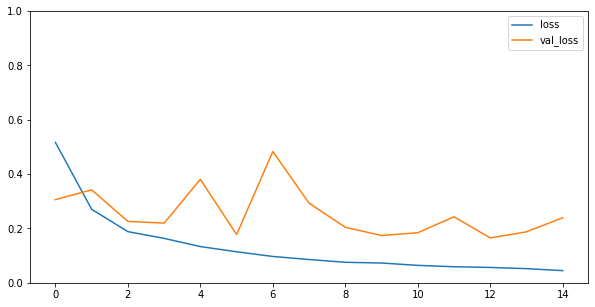

In [14]:
plt.figure(figsize=(10,5))
plt.plot(history_dict["loss"],label="loss")
plt.plot(history_dict["val_loss"],label="val_loss")
plt.ylim(0, 1)
plt.legend()

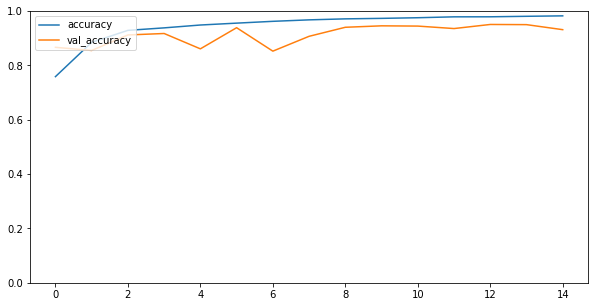

In [15]:
plt.figure(figsize=(10,5))
plt.plot(history_dict["binary_accuracy"],label="accuracy")
plt.plot(history_dict["val_binary_accuracy"],label="val_accuracy")
plt.ylim(0, 1)
plt.legend(loc='upper left')

## Evaluation

* The following section evaluates the trained model on the test set and the complete training set.
* The model that achieved best validation accuracy during training is used.


In [16]:
datagen_eval = ImageDataGenerator(preprocessing_function=datagen.preprocessing_function)
train_gen, _, test_gen = get_generators(datagen_eval, TRAIN_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE, CHANNEL_CNT, True, RAND_SEED)

best_cnn = tf.keras.models.load_model(model_save)

# test set evaluation
score = best_cnn.evaluate(x=test_gen, verbose=1)

Found 15952 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
13/13 [==============================] - 34s 3s/step - loss: 0.1107 - binary_accuracy: 0.9575


In [17]:
# training set evaluation
score = best_cnn.evaluate(x=train_gen, verbose=1)

499/499 [==============================] - 428s 858ms/step - loss: 0.0900 - binary_accuracy: 0.9695


In [18]:
# calculation of other metrics based on the test set performance
test_gen.reset()
y_pred_prob = best_cnn.predict_generator(test_gen)
y_pred = y_pred_prob.copy()
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

y_true = np.asarray(test_gen.classes[test_gen.index_array])
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

In [19]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       200
           1       0.99      0.92      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



In [20]:
# Sensitivity (TPR)
tp/(tp+fn)

0.92

In [21]:
# Specificity (TNR)
tn/(tn+fp)

0.995

In [22]:
# Positive Predictive Value (PPV)
tp/(tp+fp)

0.9945945945945946

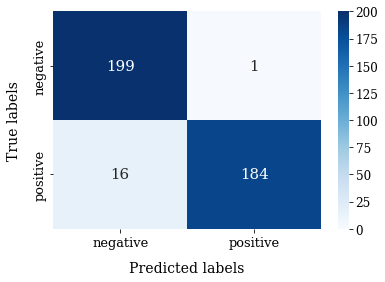

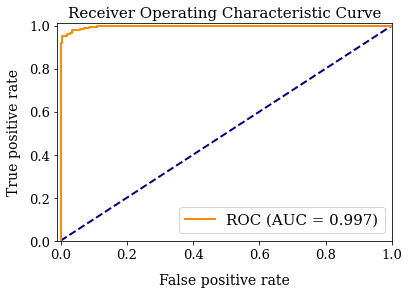

In [23]:
plot_eval(y_true, y_pred_prob, y_pred)



---




# Optimizer Selection Results (COVIDx8B)

| Model architecture | Optimizer | Learning rate | Best epoch   | Train accuracy | Validation accuracy | Test accuracy |
|-------|-------|-------|-------|-------|-------|-------|
|BaseNet|SGD|0.01|2|0.8647|0.86485|0.5|
|BaseNet|SGD|0.001|3|0.8647|0.8648|0.5|
|BaseNet|SGD|0.0001|9|0.5984|0.61179|0.5625|
|BaseNet|SGD|0.00001|3|0.8647|0.8575|0.5|
|BaseNet|RMSprop|0.01|2|0.8647|0.8648|0.5|
|BaseNet|RMSprop|0.001|1|0.8647|0.8648|0.5|
|BaseNet|RMSprop|0.0001|9|0.968|0.9323|0.9025|
|BaseNet|RMSprop|0.00001|10|0.9061|0.87802|0.787|
|BaseNet|Adam|0.01|3|0.8647|0.8648|0.5|
|BaseNet|Adam|0.001|4|0.8647|0.8648|0.5|
|BaseNet|Adam|0.0001|8|0.9519|0.90938|0.9375|
|BaseNet|Adam|0.00001|9|0.931|0.89370|0.8675|
|BaseNet|Nadam|0.01|2|0.8647|0.8648|0.5|
|BaseNet|Nadam|0.001|2|0.8647|0.8648|0.5|
|BaseNet|Nadam|0.0001|7|0.9539|0.91283|0.8900|
|BaseNet|Nadam|0.00001|10|0.9093|0.87237|0.8525|





## Image Preprocessing Results (COVIDx8B)


| Model architecture | Preprocessing | Train accuracy | Test accuracy | COVID-19 Sensitivity | COVID-19 Specificity | AUC | PPV |
|-------|-------|-------|-------|-------|-------|-------|-------|
|BaseNet|Normalization (crossval was better)|0.9833|0.9275|0.87|0.985|0.982|0.9831|
|BaseNet|RGB Histogram equalization|0.9809|0.8550|0.72|0.99|0.968|0.9863|
|BaseNet|RGB CLAHE (clip limit 40)|0.9840|0.8850|0.785|0.985|0.978|0.9813|
|BaseNet|RGB CLAHE (clip limit 3)|0.9813|0.8975|0.82|0.975|0.976|0.9704|
|BaseNet|Diapragm removal|0.9812|0.8975|0.83|0.965|0.969|0.9595|

## Data Augmentation and Oversampling Results (COVIDx8B)

| Model architecture | Technique | Train accuracy | Test accuracy | COVID-19 Sensitivity | COVID-19 Specificity | AUC | PPV |
|-------|-------|-------|-------|-------|-------|-------|-------|
|BaseNet|Class weights | 0.9831|0.9275|0.87|0.985|0.977|0.9831|
|BaseNet|Online augmentation|0.9729|0.9400|0.885|0.995|0.986|0.9944|
|BaseNet|Oversampling (ratio 1)|0.9946|0.9125|0.835|0.99|0.986|0.9882|
|BaseNet|Oversampling with augmentation (ratio 1)|0.9561|0.80|0.605|0.995|0.942|0.9918|


## Fine-tuning Results (COVIDx8B)

| Model architecture | Technique | Source data | Train accuracy | Test accuracy | COVID-19 Sensitivity | COVID-19 Specificity | AUC | PPV |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|
|VGG16|Fine-tuning|ImageNet|0.9882|0.9750|0.95|1.0|0.998|1.0|
|VGG19|Fine-tuning|ImageNet|0.9865|0.9625|0.925|1.0|0.998|1.0|
|ResNet-50|Fine-tuning|ImageNet|0.9908|0.9575|0.92|0.995|0.997|0.9946|
|DenseNet-121|Fine-tuning|ImageNet|0.9932|0.9575|0.915|1.0|1.0|1.0|
|DenseNet-121|Fine-tuning|ChestXray-14|0.9996|0.9650|0.935|0.995|0.997|0.9947|
|Xception|Fine-tuning|ImageNet|0.9935|0.9550|0.91|1.0|1.0|1.0|
